In [ ]:
!pip install git+https://github.com/DeepTrackAI/deeplay

# Image super-resolution with DDPM

We'll build a denoising diffusion probabilistic model (DDPM) for converting low-resolution images to high-resolution images.

## The BioSR dataset

We will use the BioSR dataset from the resource: [BioSR: a biological image dataset for super-resolution microscopy](https://figshare.com/articles/dataset/BioSR/13264793). BioSR is a biological image dataset for super-resolution microscopy. It contains low-resolution and high resolution images of four biological structures: Clathrin-coated pits (CCPs), endoplasmic reticulum (ER), microtubules (MTs), and F-actin filaments (F-actin). For this project, we will use the Microtubules (MTs) images.

We have preprocessed the MTs images from their raw format to a format that can be used for training the model. The processed dataset is available at [biosr_dataset](https://github.com/deeptrackai/biosr_dataset/) GitHub repository. The repository contains 40320 image pairs for training, and 2080 image pairs for validation.

We will download the dataset using the `git clone` command, and then change the current working directory to the `biosr_dataset` directory using the following commands:
    
```bash
    !git clone https://github.com/DeepTrackAI/biosr_dataset.git
    !cd biosr_dataset
```

We will run the above command in the next code cell.

In [1]:
# !git clone https://github.com/DeepTrackAI/biosr_dataset.git
# !cd biosr_dataset

We will create a custom dataset class `BioSRDataset` using the `torch.utils.data.Dataset` class. Once defined, the dataset class can be used like any other PyTorch dataset (e.g., any of the datasets in `torchvision.datasets`). The dataset class enables the use of the PyTorch DataLoader, which automatically handles data loading, shuffling, and batching.

In [2]:
import os
import numpy as np
from torch.utils.data import Dataset
import torch
from tifffile import tifffile

def normalize_uint8(img):
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = (img * 255).astype(np.uint8)
    return img

class BioSRDataset(Dataset):
    """
    Custom dataset class for the BioSR dataset.
    """
    def __init__(self, root, train=True, transform=None):
        self.root = root
        self.transform = transform
        self.train = train

        if self.train:
            self.input_dir = os.path.join(root, "training_wf")
            self.target_dir = os.path.join(root, "training_gt")
        else:
            self.input_dir = os.path.join(root, "validate_wf")
            self.target_dir = os.path.join(root, "validate_gt")

        file_list = os.listdir(self.input_dir)
        self.file_list = [file for file in file_list if file.endswith(".tif")]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):

        input_path = os.path.join(self.input_dir, self.file_list[idx])
        target_path = os.path.join(self.target_dir, self.file_list[idx])

        input_image = normalize_uint8(tifffile.imread(input_path))
        target_image = normalize_uint8(tifffile.imread(target_path))

        if self.transform:
            seed = np.random.randint(2147483647)
            torch.manual_seed(seed)
            input_image = self.transform[0](input_image)

            torch.manual_seed(seed)
            target_image = self.transform[1](target_image)

        return input_image, target_image

We will define the transforms to be applied to the images using `torchvision.transforms` module. 

The low-resolution images are of size 128x128, and the high-resolution images are of size 256x256. To make the model memory efficient, we will first resize the images to 64x64 and 128x128, respectively. 

In the next step, we will resize the input images (low-resolution images) to 128x128 through bicubic interpolation to match the size of the output image (high-resolution images). This process is required to ensure that the input and output images have the same size while training the model. 

Finally we will normalize the images to have pixel values between -1 and 1, which is a common practice for training DDPM models.

In [3]:
from torchvision import transforms

transform = [
    # Transform for the input image
    transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((64, 64), antialias=True),  # From original 128x128 to 64x64
            transforms.Resize(
                (128, 128), interpolation=transforms.InterpolationMode.BICUBIC, antialias=True
            ), # From 64x64 to 128x128
            transforms.Normalize((0.5,), (0.5,)), # Normalize to [-1, 1]
        ]
    ),
    # Transform for the target image
    transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((128, 128), antialias=True),  # From original 256x256 to 128x128
            transforms.Normalize((0.5,), (0.5,)), # Normalize to [-1, 1]
        ]
    ),
]

We will now use the `BioSRDataset` class to create the training and validation datasets. The dataset folder is passed through the `root`argument, and the transforms are passed through the `transform` argument.

The `train` argument is set to `True` to create the training dataset, and `False` to create the validation dataset.

In [4]:
PATH = "/data/BioSR/Microtubules"

train_dataset = BioSRDataset(root=PATH, train=True, transform=transform)
val_dataset = BioSRDataset(root=PATH, train=False, transform=transform)

print(len(train_dataset), len(val_dataset))

40320 2080


We will visualise some images from the training dataset using the `matplotlib` package.

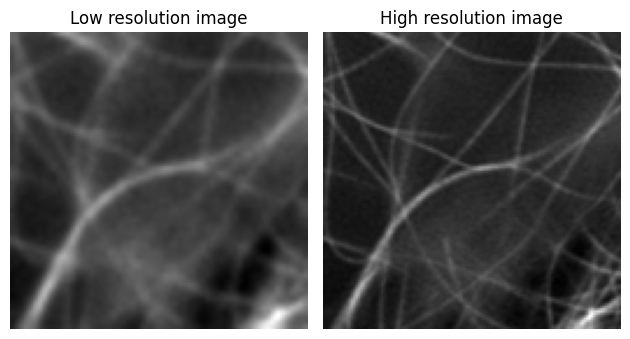

In [5]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

# Get a random sample from the training dataset
low_res_image, high_res_image = train_dataset[np.random.randint(0, len(train_dataset))]

# Plot the images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(low_res_image.permute(1, 2, 0), cmap='gray')
plt.title('Low resolution image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(high_res_image.permute(1, 2, 0), cmap='gray')
plt.title('High resolution image')
plt.axis('off')
plt.tight_layout()
plt.show()

We now define the `device` to be used for training the model. We will use the GPU if it's available, otherwise we will use the CPU. The `torch.cuda.is_available()` function returns `True` if the GPU is available, otherwise it returns `False`.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
print(device)

cuda


## Diffusion process


In this section we will implement the forward and the reverse diffusion processes by defining the `Diffusion` class.

We define the `Diffusion` class with the following methods:
1. `prepare_noise_schedule`: Prepares the noise schedule based on the given `beta_start` and `beta_end` parameters, and the number of steps given by the parameter `noise_steps`.
2. `noise_images`: Implements the forward diffusion process. Given an input image `x`, and the time step `t`, it returns the noisy image `x_t`.
3. `sample_timesteps`: Generates `n` random time steps. This is used during the training process to generate a batch of random time steps for the forward diffusion process.
4. `sample_test_image`: Implements the reverse diffusion process. Generates an image from pure noise.

We will add additional attribute, `input_image`, to the `sample_test_image` method. This will allow us to generate images from image conditioned inputs, unlike in the previous projects, where we generated images by conditioning on class labels and textual inputs.

In [8]:
from tqdm import tqdm

class Diffusion:
    def __init__(
        self,
        noise_steps=1000,
        beta_start=1e-4,
        beta_end=0.02,
        img_size=256,
        device="cuda:0" if torch.cuda.is_available() else "cpu",
    ):
        """
        Parameters
        ----------
        noise_steps : int, optional
                Number of steps in the diffusion process, by default 1000
        beta_start : float, optional
                Starting value of the variance schedule $\beta_t$, by default 1e-4
        beta_end : float, optional
                Ending value of the variance schedule $\beta_t$, by default 0.02
        img_size : int, optional
                Size of the image, by default 256
		device : str, optional
			Device to use for the computations, by default "cuda:0" if torch.cuda.is_available() else "cpu"
        """
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(
            device
        )  # This will create a list of betas from beta_start to beta_end using the prepare_noise_schedule function
        self.alpha = 1.0 - self.beta  # This will create the list of alphas
        self.alpha_bar = torch.cumprod(
            self.alpha, dim=0
        )  # This will create a list of alpha_bars up to the current time step

    def prepare_noise_schedule(self):
        return torch.linspace(
            self.beta_start, self.beta_end, self.noise_steps
        )  # linear schedule

    def noise_images(self, x, t):
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])[
            :, None, None, None
        ]
        noise = torch.randn_like(x)

        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,)).to(self.device)

    def sample_test_images(
        self,
        model,
        n,  # Number of images to sample
        n_channels,  # Number of channels in the image
        position_encoding_dim, # Dimension of the positional encoding
        position_encoding_function, # Positional encoding function
        fixed_noise=None,
        save_time_steps=None,
        save_every=200,  # Store the denoised images every "save_every" steps
        class_labels=None,
        cfg=False,
        cfg_guidance_strength=3,
        context=None,
        input_image=None,
    ):
        """
        Sample images from the model at different timesteps of the reverse diffusion process.

        Parameters
        ----------
        model : nn.Module
                Model to sample from (prettrained diffusion model)
        n : int
                Number of images to sample
        n_channels : int
                Number of channels in the image
        position_encoding_dim : int
                Dimension of the positional encoding.
        position_encoding_function : function
                Positional encoding function. Function to encode the time step t. For example., sinusoidal position encoding.
        fixed_noise : torch.Tensor, optional
                Fixed noise to use for the sampling, by default None.
        save_time_steps : list, optional
                List of time steps to save the denoised images, by default None.
        save_every : int, optional
                Store the denoised images every "save_every" steps, by default 200
        class_labels : torch.Tensor, optional
                Class labels for the images, by default None
        cfg : bool, optional
                Enable classifier-free guidance. Used for class-conditioned DDPM models. By default False.
        cfg_guidance_strength : int, optional
                Strength of the classifier-free guidance, by default 3
        context : torch.Tensor, optional
                Context for the model, by default None. Used for text-to-image models.
        input_image : torch.Tensor, optional
                Input image to use for the sampling, by default None
        """
        with torch.no_grad():
            denoised_images = []
            if fixed_noise is not None:
                x = fixed_noise.to(self.device)
            else:
                x = torch.randn((n, n_channels, self.img_size, self.img_size)).to(
                    self.device
                )

            for i in tqdm(
                reversed(range(1, self.noise_steps)),
                desc="UNet inference",
                total=self.noise_steps,
            ):
                t = (torch.ones(n) * i).long()
                t_expdims = position_encoding_function(t.unsqueeze(1), position_encoding_dim).to(self.device)

                if cfg:
                    conditional_prediction = model(x, t_expdims, class_labels)
                    unconditional_prediction = model(x, t_expdims, None)
                    predicted_noise = torch.lerp(
                        unconditional_prediction,
                        conditional_prediction,
                        cfg_guidance_strength,
                    )
                elif context is not None:
                    predicted_noise = model(
                        x, t_expdims, y=class_labels, context=context
                    )
                elif input_image is not None:
                    predicted_noise = model(
                        torch.cat((input_image.to(self.device), x), dim=1),
                        t_expdims,
                    )
                else:
                    predicted_noise = model(x, t_expdims, y=class_labels)
                
                alpha = self.alpha[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]

                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = (
                    1
                    / torch.sqrt(alpha)
                    * (
                        x
                        - ((1 - alpha) / (torch.sqrt(1 - alpha_bar))) * predicted_noise
                    )
                    + torch.sqrt(beta) * noise
                )

                if save_time_steps is not None:
                    if i in save_time_steps:
                        denoised_images.append(x)
                else:
                    if i % save_every == 1:
                        denoised_images.append(x)

            denoised_images = torch.stack(denoised_images)
            denoised_images = denoised_images.swapaxes(0, 1)
            return denoised_images

## Attention UNet

In this section we will define the Attention UNet that is used in the DDPM model.

We use the class `AttentionUNet` from deeplay to define the Attention UNet architecture. It takes the noisy image and the time step corresponding to the noisy image as input, and returns the noise added to the image as output.

The input channels and output channels are defined the parameters `in_channels` and `out_channels` respectively. The `channels` parameter defines the number of channels in the hidden layers of the UNet, i.e., the number of convolutional filters in the hidden layers.

The `base_channels` parameter defines the number of channels at the base of the UNet, between the encoder and the decoder.

The `channel_attention` parameter can be used to control of attention mechanism that is applied at hidden channels. The boolean values (True or False) defined by the `channel_attention` parameter are used to control the attention mechanism. The first boolean value will be ignored as the time step attention is not included in the first hidden channel. When performing an ablation study, set the attention mechanism to `False` from the end of the list.

The `position_embedding_dim` parameter is used to indicate the dimension of the position encoding of the time step. We will look at it in more detail in the next step.

In [9]:
import deeplay as dl

EMBEDDING_DIM = 256

model = dl.AttentionUNet(
    in_channels=2, # Since we are using the noise and the image as input
    channels=[32, 64, 128], # Since the image size is 28x28, we cannot use more than three channels
    base_channels=[256, 256],
    out_channels=1,
    channel_attention=[True, True, True],
    position_embedding_dim=EMBEDDING_DIM,
)
model.build()
model.to(device)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttentionUNet(
  (encoder): UNetEncoder(
    (conv_block1): DoubleConvBlock(
      (blocks): LayerList(
        (0): Block(
          (layer): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
          (activation): GELU(approximate='none')
        )
        (1): Block(
          (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
          (activation): Identity()
        )
      )
    )
    (blocks): LayerList(
      (0): FeatureIntegrationModule(
        (conv_block): Sequential(
          (0): DoubleConvBlock(
            (blocks): LayerList(
              (0): Block(
                (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
                (activation): GELU(approximate='none')
              )
          

We will define the position encoding function, `positional_encoding` to convert the time step from a singular value to a position encoding vector. Instead of passing the time step as a singular value, we will pass it as a position encoding vector to the Attention UNet.

In [10]:
def positional_encoding(t, emb_dim):
	inv_freq = 1.0 / (10000 ** (torch.arange(0, emb_dim, 2).float() / emb_dim))
	inv_freq = inv_freq.to(t.device)
	pos_enc_a = torch.sin(t.repeat(1, emb_dim // 2) * inv_freq)
	pos_enc_b = torch.cos(t.repeat(1, emb_dim // 2) * inv_freq)
	pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
	return pos_enc

### Optimizers

We will define the optimizer and learning rate for the model. We will use the Adam optimizer with a learning rate of 1e-4.

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

### Loss function

We will use a L1 loss function to train the model.

In [12]:
criterion = torch.nn.L1Loss()

### Data loaders

We now define the data loaders for the training and val datasets. We will use a batch size of `64` as defined by the `batch_size` parameter. We will also set the `shuffle` parameter to `True` for the training data loader to shuffle the training dataset.

In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Training procedure

We now define an instance of the `Diffusion` class with 2000 noise steps for training the model. We will use a `beta_start` of 1e-6 and a `beta_end` of 0.01.

In [14]:
IMAGE_SIZE = 128
NOISE_STEPS = 2000
BETA_START = 1e-6
BETA_END = 0.01
EMBEDDING_DIM = 256

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

diffusion = Diffusion(
    noise_steps=NOISE_STEPS,
    beta_start=BETA_START,
    beta_end=BETA_END,
    img_size=IMAGE_SIZE,
    device=device,
)

We now define a helper function `prepare_data` to prepare the data for training the model. The function takes input image and the target image as inputs, and returns the noise image concatenated with the input image, time step embedding, and the noise added to the target image. The former two are used as inputs to the Attention UNet, and the latter is used as the target for training the model.

In [15]:
def prepare_data(input_image, target_image, device=device):
    
    # Generate noise and timesteps and apply diffusion
    batch_size = input_image.shape[0]
    t = diffusion.sample_timesteps(batch_size)

    input_image = input_image.to(device)  # low res image
    target_image = target_image.to(device)  # high res image

    x_t, noise = diffusion.noise_images(target_image, t)

    t = positional_encoding(t.unsqueeze(1), EMBEDDING_DIM)

    # Concatenate the noise image with the image
    x_t = torch.cat((input_image, x_t), dim=1)

    # Move to device
    x_t = x_t.to(device)
    t = t.to(device)
    noise = noise.to(device)

    return x_t, t, noise

We will define a helper function `denormalize` to denormalize the images for visualisation.

In [16]:
def denormalize(image):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = image * 0.5 + 0.5
    image = image - image.min()
    image = image / (image.max() - image.min())
    return image

We now define the training loop for the DDPM model for generating high-resolution images from low-resolution images. We will train the model for 30 defined by the `EPOCHS` parameter.

Once every epoch, we will print the losses, time taken for the epoch, and also visualize the generated images.



Epoch 1 / 30
__________
Batch 1 / 630: Train loss: 1.0282
Batch 201 / 630: Train loss: 0.1204
Batch 401 / 630: Train loss: 0.0906
Batch 601 / 630: Train loss: 0.0948
----------
Epoch 1/30 : Train loss: 0.1404
Time elapsed: 0:12:23.641545 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:03<00:00, 31.37it/s]


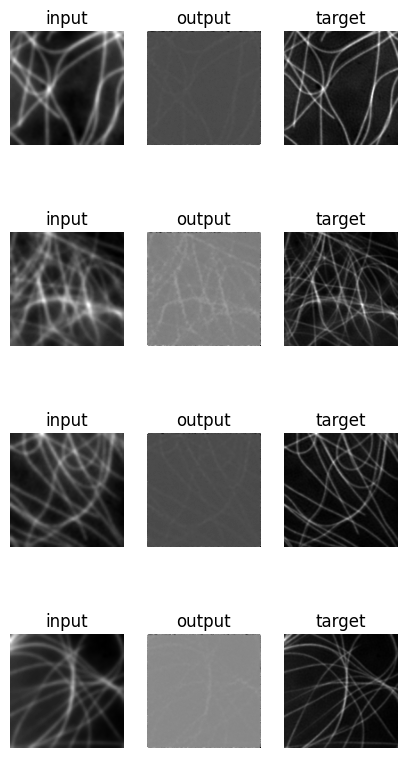



Epoch 2 / 30
__________
Batch 1 / 630: Train loss: 0.0879
Batch 201 / 630: Train loss: 0.0925
Batch 401 / 630: Train loss: 0.0803
Batch 601 / 630: Train loss: 0.0753
----------
Epoch 2/30 : Train loss: 0.0810
Time elapsed: 0:12:35.905807 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:06<00:00, 30.22it/s]


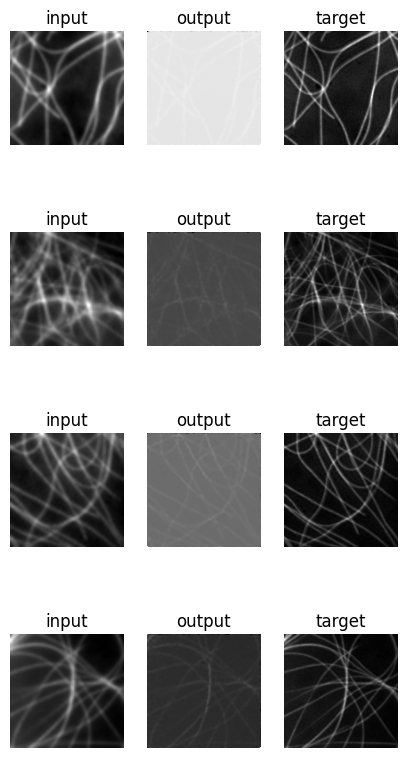



Epoch 3 / 30
__________
Batch 1 / 630: Train loss: 0.0737
Batch 201 / 630: Train loss: 0.0687
Batch 401 / 630: Train loss: 0.0676
Batch 601 / 630: Train loss: 0.0797
----------
Epoch 3/30 : Train loss: 0.0696
Time elapsed: 0:12:21.912421 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:00<00:00, 32.92it/s]


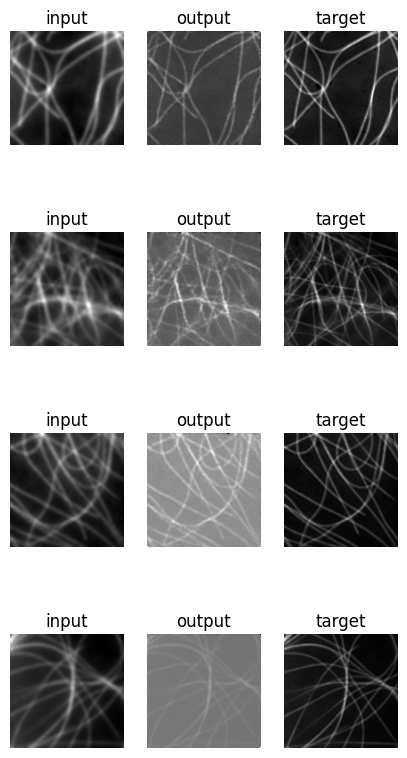



Epoch 4 / 30
__________
Batch 1 / 630: Train loss: 0.0700
Batch 201 / 630: Train loss: 0.0667
Batch 401 / 630: Train loss: 0.0571
Batch 601 / 630: Train loss: 0.0640
----------
Epoch 4/30 : Train loss: 0.0640
Time elapsed: 0:12:14.425635 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:23<00:00, 23.96it/s]


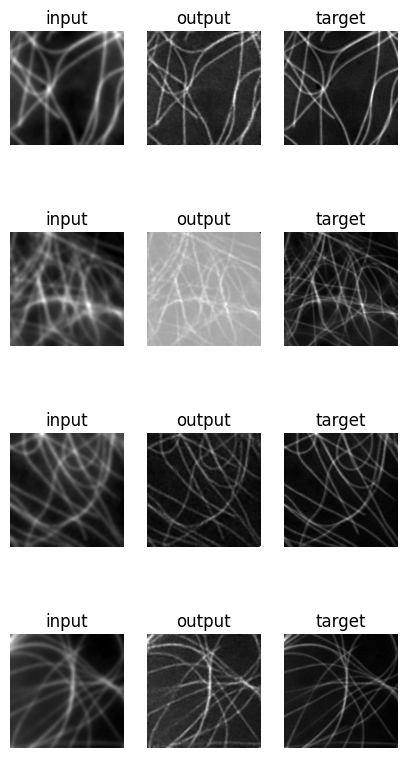



Epoch 5 / 30
__________
Batch 1 / 630: Train loss: 0.0570
Batch 201 / 630: Train loss: 0.0473
Batch 401 / 630: Train loss: 0.0468
Batch 601 / 630: Train loss: 0.0432
----------
Epoch 5/30 : Train loss: 0.0586
Time elapsed: 0:12:18.104310 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:21<00:00, 24.39it/s]


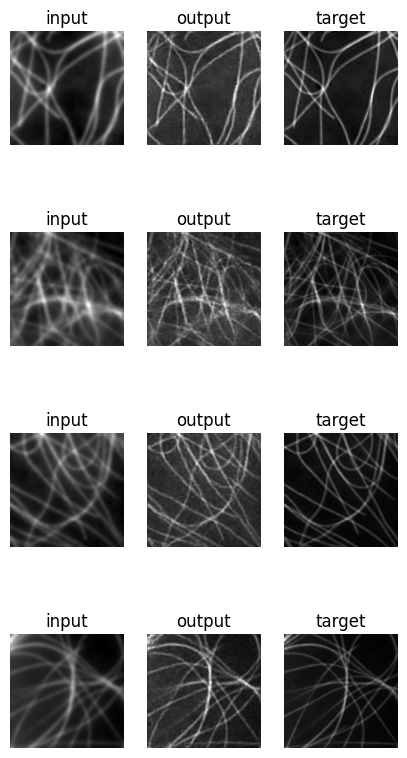



Epoch 6 / 30
__________
Batch 1 / 630: Train loss: 0.0489
Batch 201 / 630: Train loss: 0.0695
Batch 401 / 630: Train loss: 0.0436
Batch 601 / 630: Train loss: 0.0503
----------
Epoch 6/30 : Train loss: 0.0538
Time elapsed: 0:12:15.185037 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:04<00:00, 30.94it/s]


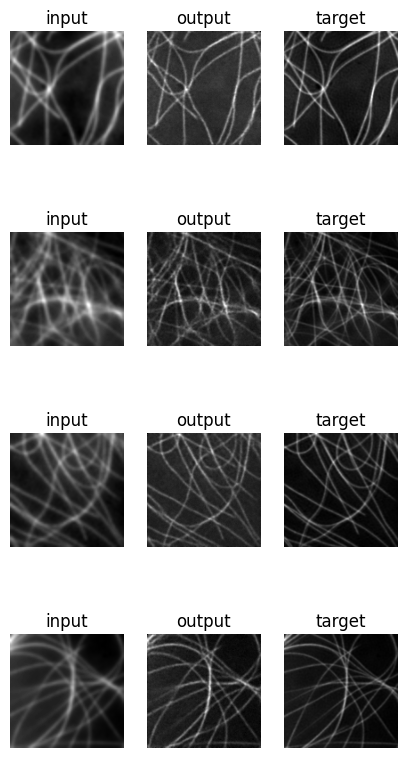



Epoch 7 / 30
__________
Batch 1 / 630: Train loss: 0.0510
Batch 201 / 630: Train loss: 0.0536
Batch 401 / 630: Train loss: 0.0485
Batch 601 / 630: Train loss: 0.0412
----------
Epoch 7/30 : Train loss: 0.0501
Time elapsed: 0:12:21.723189 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [00:53<00:00, 37.35it/s]


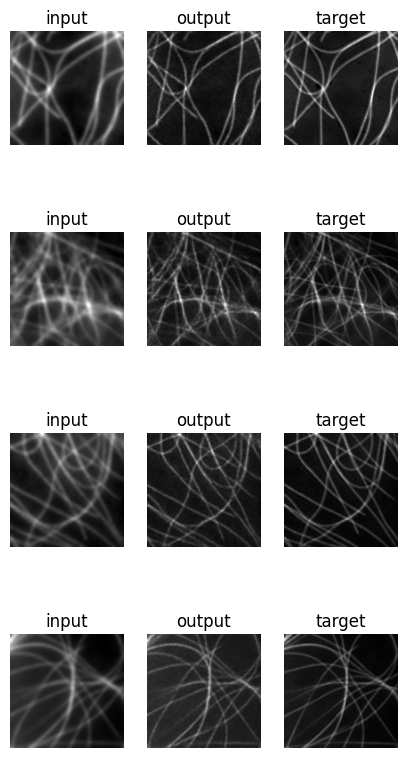



Epoch 8 / 30
__________
Batch 1 / 630: Train loss: 0.0645
Batch 201 / 630: Train loss: 0.0656
Batch 401 / 630: Train loss: 0.0473
Batch 601 / 630: Train loss: 0.0496
----------
Epoch 8/30 : Train loss: 0.0500
Time elapsed: 0:12:31.176474 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:07<00:00, 29.77it/s]


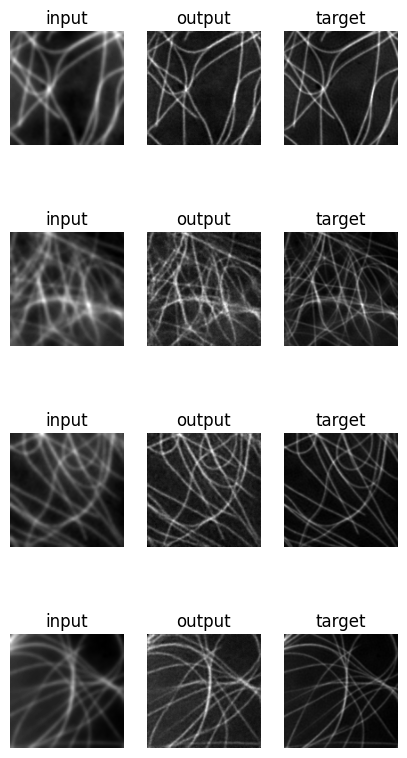



Epoch 9 / 30
__________
Batch 1 / 630: Train loss: 0.0368
Batch 201 / 630: Train loss: 0.0585
Batch 401 / 630: Train loss: 0.0446
Batch 601 / 630: Train loss: 0.0635
----------
Epoch 9/30 : Train loss: 0.0487
Time elapsed: 0:12:27.709321 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:06<00:00, 30.01it/s]


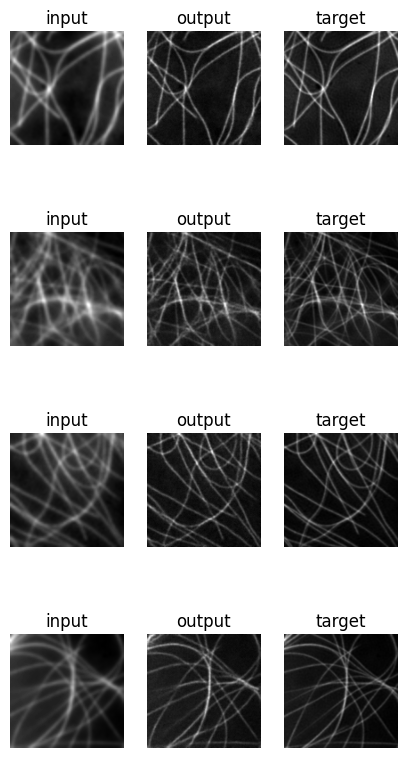



Epoch 10 / 30
__________
Batch 1 / 630: Train loss: 0.0491
Batch 201 / 630: Train loss: 0.0496
Batch 401 / 630: Train loss: 0.0494
Batch 601 / 630: Train loss: 0.0456
----------
Epoch 10/30 : Train loss: 0.0473
Time elapsed: 0:12:22.199247 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:09<00:00, 28.60it/s]


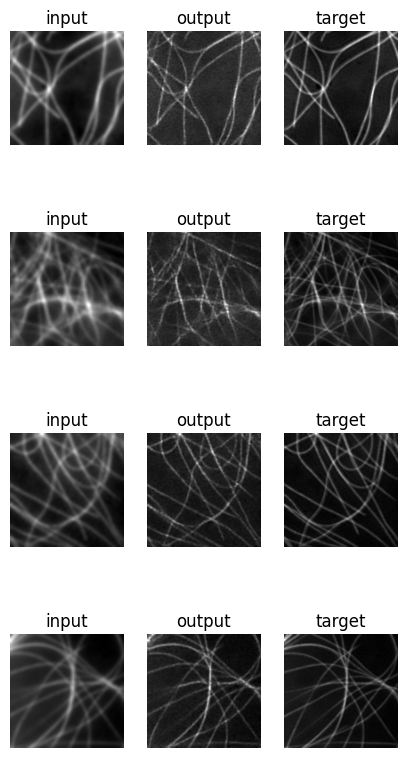



Epoch 11 / 30
__________
Batch 1 / 630: Train loss: 0.0427
Batch 201 / 630: Train loss: 0.0466
Batch 401 / 630: Train loss: 0.0553
Batch 601 / 630: Train loss: 0.0313
----------
Epoch 11/30 : Train loss: 0.0471
Time elapsed: 0:12:18.048453 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:18<00:00, 25.44it/s]


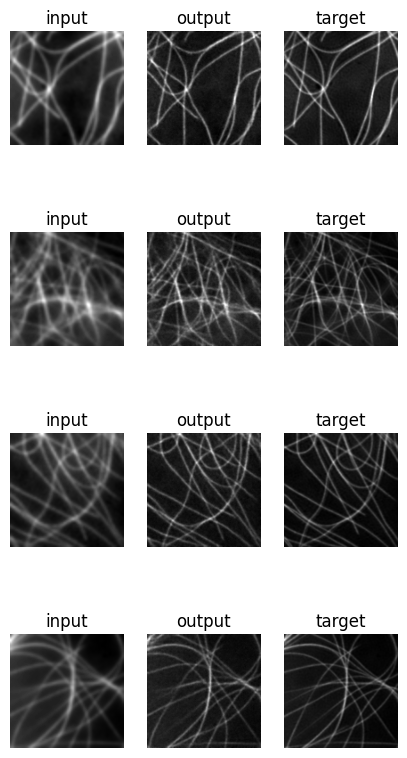



Epoch 12 / 30
__________
Batch 1 / 630: Train loss: 0.0415
Batch 201 / 630: Train loss: 0.0289
Batch 401 / 630: Train loss: 0.0481
Batch 601 / 630: Train loss: 0.0284
----------
Epoch 12/30 : Train loss: 0.0450
Time elapsed: 0:12:25.388642 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:16<00:00, 26.08it/s]


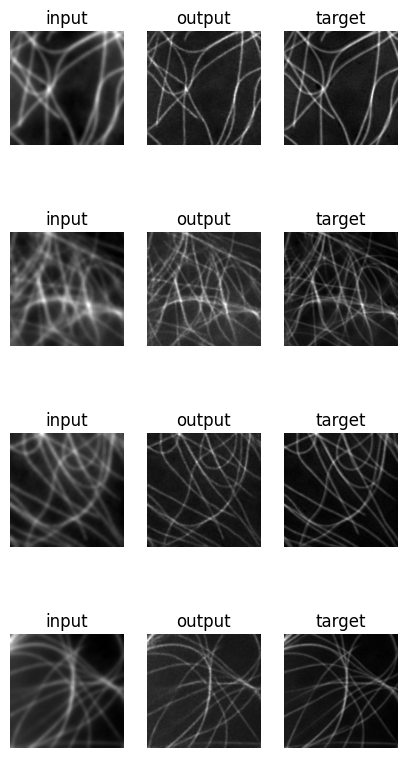



Epoch 13 / 30
__________
Batch 1 / 630: Train loss: 0.0495
Batch 201 / 630: Train loss: 0.0447
Batch 401 / 630: Train loss: 0.0301
Batch 601 / 630: Train loss: 0.0492
----------
Epoch 13/30 : Train loss: 0.0455
Time elapsed: 0:12:23.734618 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:17<00:00, 25.82it/s]


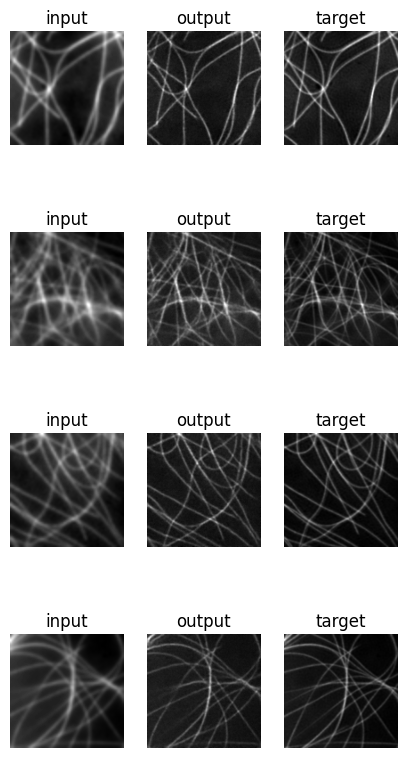



Epoch 14 / 30
__________
Batch 1 / 630: Train loss: 0.0435
Batch 201 / 630: Train loss: 0.0402
Batch 401 / 630: Train loss: 0.0416
Batch 601 / 630: Train loss: 0.0336
----------
Epoch 14/30 : Train loss: 0.0451
Time elapsed: 0:12:25.546972 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:14<00:00, 26.83it/s]


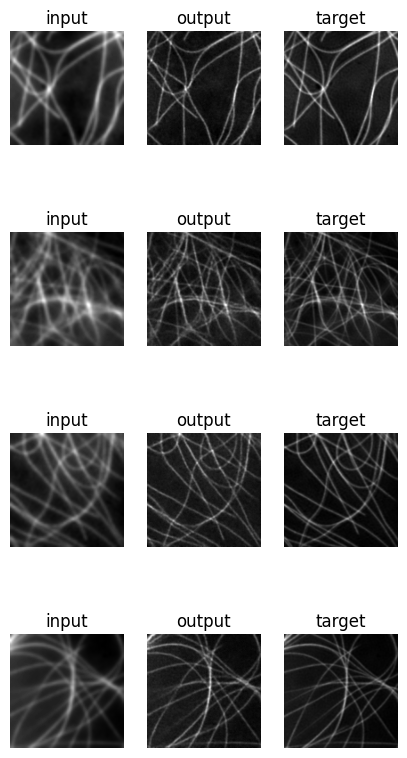



Epoch 15 / 30
__________
Batch 1 / 630: Train loss: 0.0488
Batch 201 / 630: Train loss: 0.0389
Batch 401 / 630: Train loss: 0.0568
Batch 601 / 630: Train loss: 0.0334
----------
Epoch 15/30 : Train loss: 0.0445
Time elapsed: 0:12:23.457269 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:16<00:00, 26.10it/s]


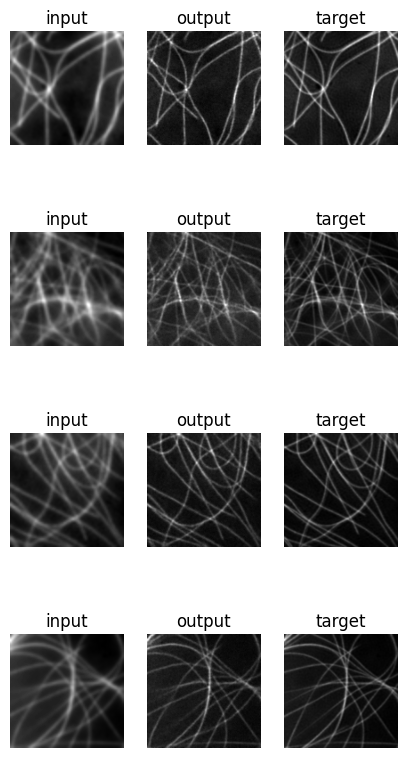



Epoch 16 / 30
__________
Batch 1 / 630: Train loss: 0.0393
Batch 201 / 630: Train loss: 0.0578
Batch 401 / 630: Train loss: 0.0449
Batch 601 / 630: Train loss: 0.0504
----------
Epoch 16/30 : Train loss: 0.0440
Time elapsed: 0:12:25.346124 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:14<00:00, 26.80it/s]


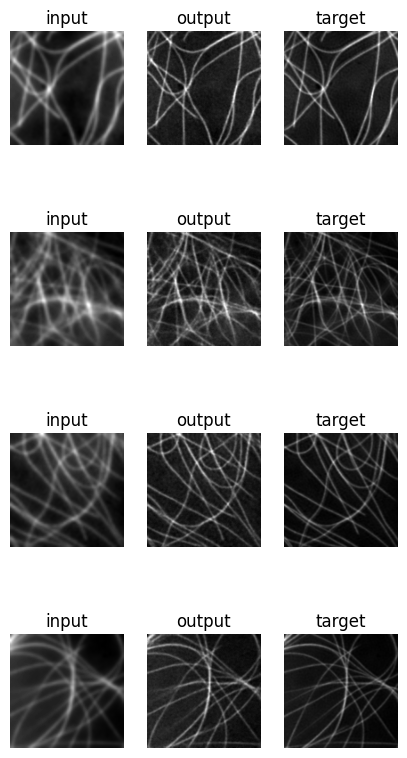



Epoch 17 / 30
__________
Batch 1 / 630: Train loss: 0.0503
Batch 201 / 630: Train loss: 0.0398
Batch 401 / 630: Train loss: 0.0433
Batch 601 / 630: Train loss: 0.0299
----------
Epoch 17/30 : Train loss: 0.0425
Time elapsed: 0:12:23.465021 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:18<00:00, 25.51it/s]


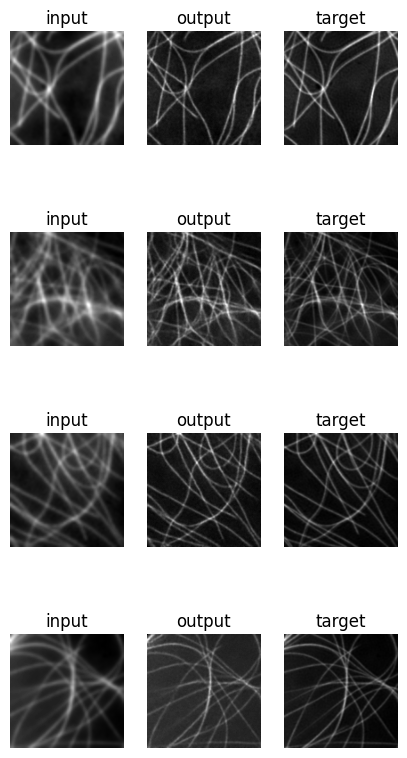



Epoch 18 / 30
__________
Batch 1 / 630: Train loss: 0.0363
Batch 201 / 630: Train loss: 0.0363
Batch 401 / 630: Train loss: 0.0403
Batch 601 / 630: Train loss: 0.0404
----------
Epoch 18/30 : Train loss: 0.0430
Time elapsed: 0:12:23.041498 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:18<00:00, 25.50it/s]


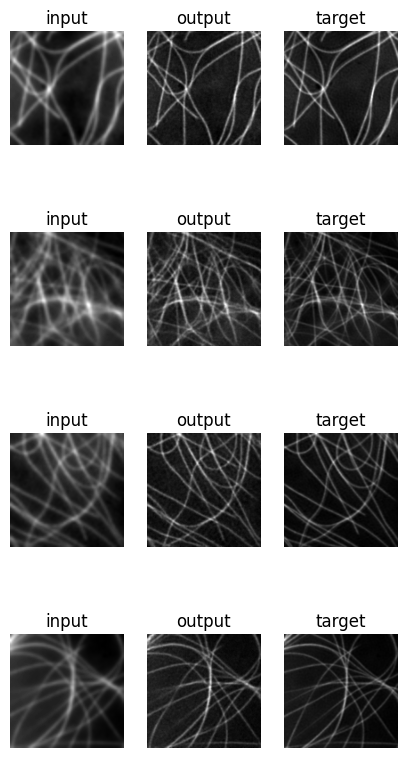



Epoch 19 / 30
__________
Batch 1 / 630: Train loss: 0.0260
Batch 201 / 630: Train loss: 0.0292
Batch 401 / 630: Train loss: 0.0478
Batch 601 / 630: Train loss: 0.0318
----------
Epoch 19/30 : Train loss: 0.0419
Time elapsed: 0:12:18.014992 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:21<00:00, 24.51it/s]


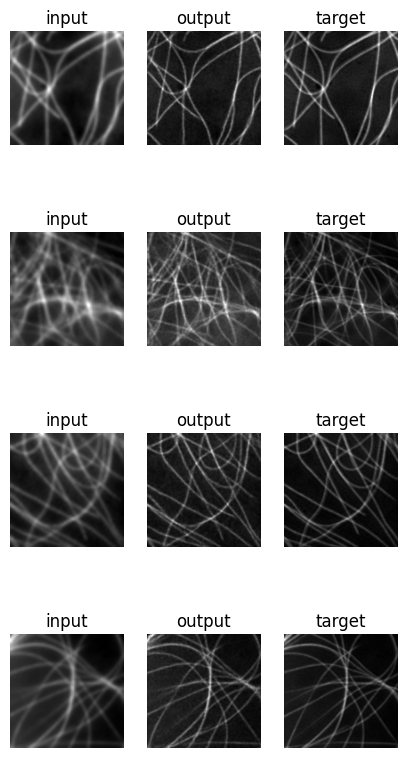



Epoch 20 / 30
__________
Batch 1 / 630: Train loss: 0.0387
Batch 201 / 630: Train loss: 0.0389
Batch 401 / 630: Train loss: 0.0414
Batch 601 / 630: Train loss: 0.0446
----------
Epoch 20/30 : Train loss: 0.0423
Time elapsed: 0:12:17.619770 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:23<00:00, 23.84it/s]


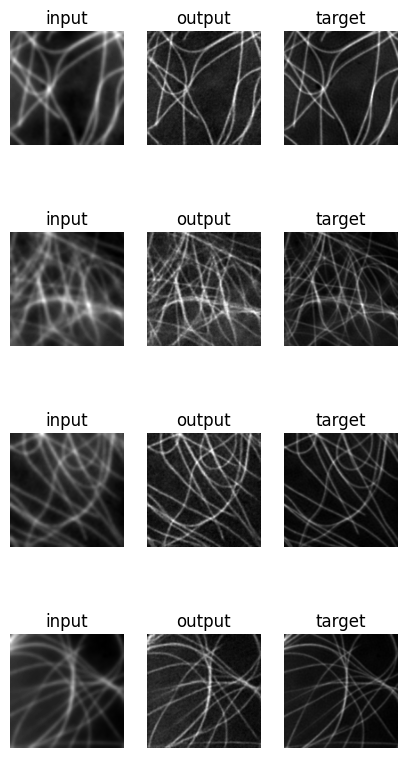



Epoch 21 / 30
__________
Batch 1 / 630: Train loss: 0.0446
Batch 201 / 630: Train loss: 0.0652
Batch 401 / 630: Train loss: 0.0380
Batch 601 / 630: Train loss: 0.0351
----------
Epoch 21/30 : Train loss: 0.0421
Time elapsed: 0:12:09.491949 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:12<00:00, 27.43it/s]


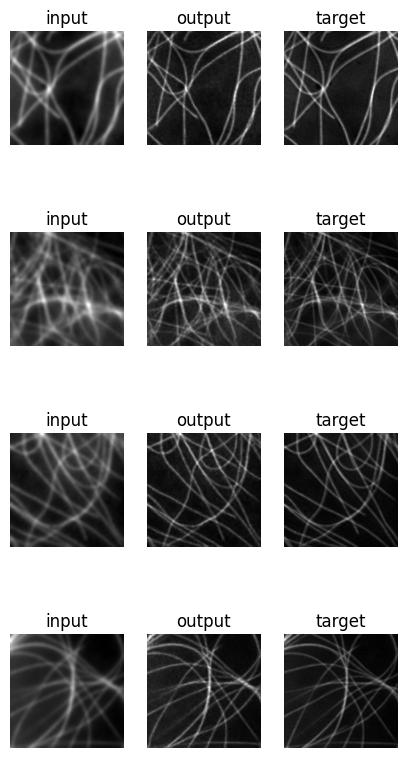



Epoch 22 / 30
__________
Batch 1 / 630: Train loss: 0.0384
Batch 201 / 630: Train loss: 0.0431
Batch 401 / 630: Train loss: 0.0358
Batch 601 / 630: Train loss: 0.0323
----------
Epoch 22/30 : Train loss: 0.0422
Time elapsed: 0:12:08.388512 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:06<00:00, 30.08it/s]


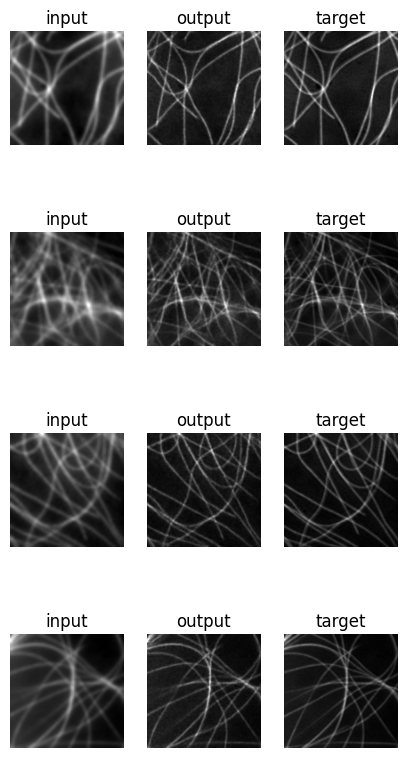



Epoch 23 / 30
__________
Batch 1 / 630: Train loss: 0.0527
Batch 201 / 630: Train loss: 0.0353
Batch 401 / 630: Train loss: 0.0267
Batch 601 / 630: Train loss: 0.0392
----------
Epoch 23/30 : Train loss: 0.0406
Time elapsed: 0:12:19.808892 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:06<00:00, 30.06it/s]


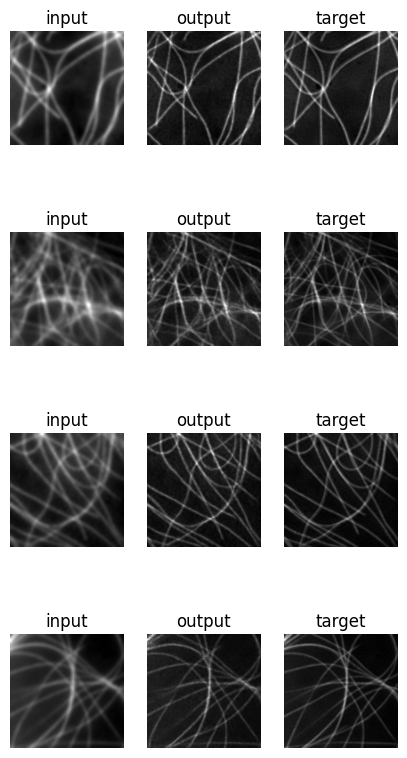



Epoch 24 / 30
__________
Batch 1 / 630: Train loss: 0.0304
Batch 201 / 630: Train loss: 0.0320
Batch 401 / 630: Train loss: 0.0525
Batch 601 / 630: Train loss: 0.0352
----------
Epoch 24/30 : Train loss: 0.0413
Time elapsed: 0:12:10.906813 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:24<00:00, 23.73it/s]


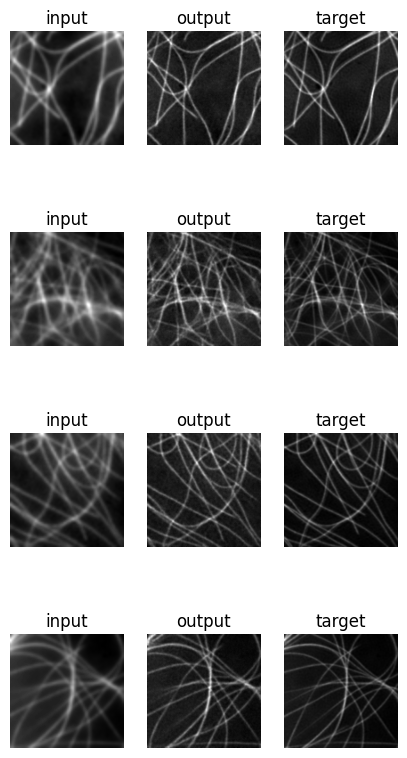



Epoch 25 / 30
__________
Batch 1 / 630: Train loss: 0.0448
Batch 201 / 630: Train loss: 0.0426
Batch 401 / 630: Train loss: 0.0385
Batch 601 / 630: Train loss: 0.0418
----------
Epoch 25/30 : Train loss: 0.0411
Time elapsed: 0:12:18.442102 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:20<00:00, 24.91it/s]


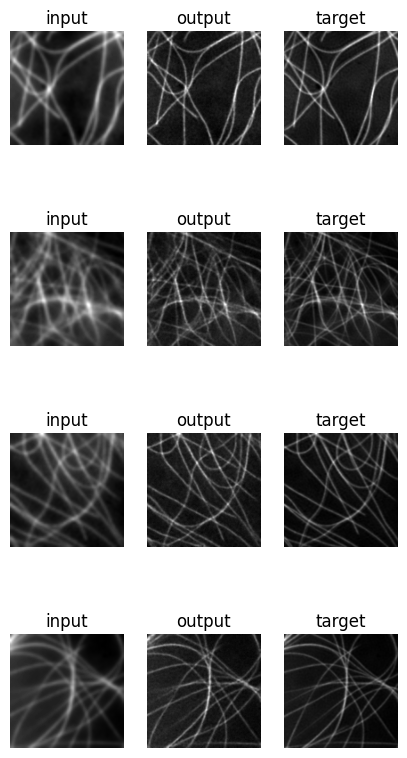



Epoch 26 / 30
__________
Batch 1 / 630: Train loss: 0.0253
Batch 201 / 630: Train loss: 0.0552
Batch 401 / 630: Train loss: 0.0446
Batch 601 / 630: Train loss: 0.0411
----------
Epoch 26/30 : Train loss: 0.0412
Time elapsed: 0:12:16.954058 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:14<00:00, 26.70it/s]


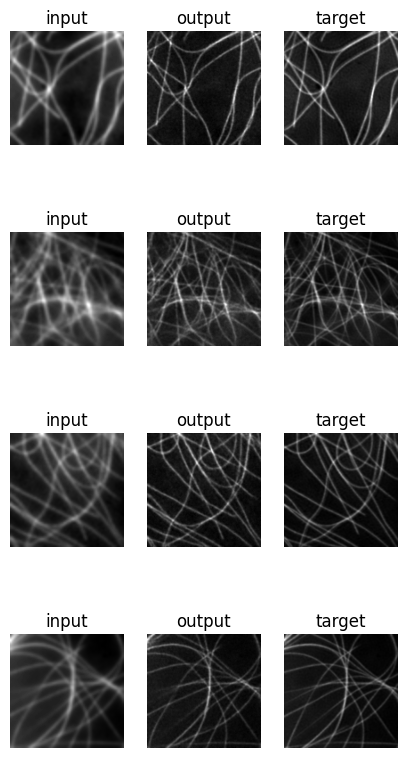



Epoch 27 / 30
__________
Batch 1 / 630: Train loss: 0.0449
Batch 201 / 630: Train loss: 0.0398
Batch 401 / 630: Train loss: 0.0510
Batch 601 / 630: Train loss: 0.0261
----------
Epoch 27/30 : Train loss: 0.0405
Time elapsed: 0:12:24.683894 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:16<00:00, 26.02it/s]


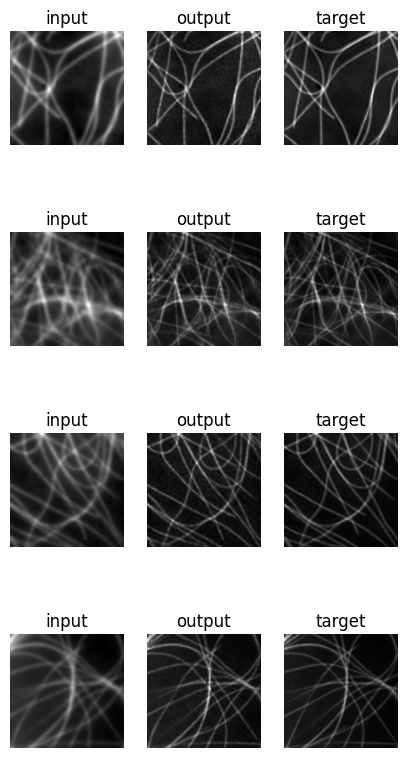



Epoch 28 / 30
__________
Batch 1 / 630: Train loss: 0.0228
Batch 201 / 630: Train loss: 0.0264
Batch 401 / 630: Train loss: 0.0403
Batch 601 / 630: Train loss: 0.0443
----------
Epoch 28/30 : Train loss: 0.0411
Time elapsed: 0:12:21.810821 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:16<00:00, 26.12it/s]


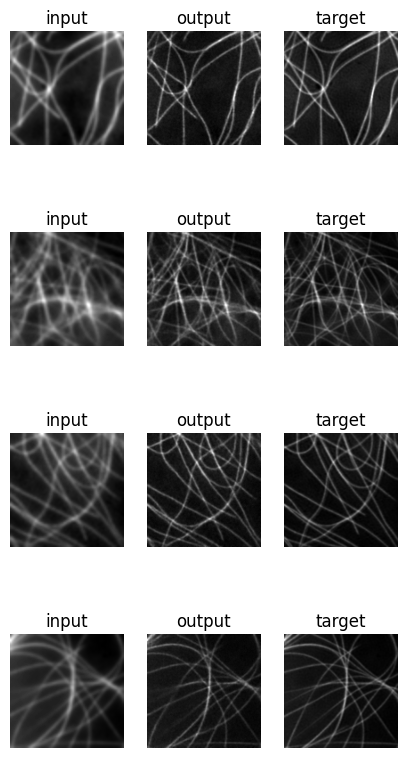



Epoch 29 / 30
__________
Batch 1 / 630: Train loss: 0.0315
Batch 201 / 630: Train loss: 0.0378
Batch 401 / 630: Train loss: 0.0350
Batch 601 / 630: Train loss: 0.0311
----------
Epoch 29/30 : Train loss: 0.0408
Time elapsed: 0:12:22.289004 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:04<00:00, 30.95it/s]


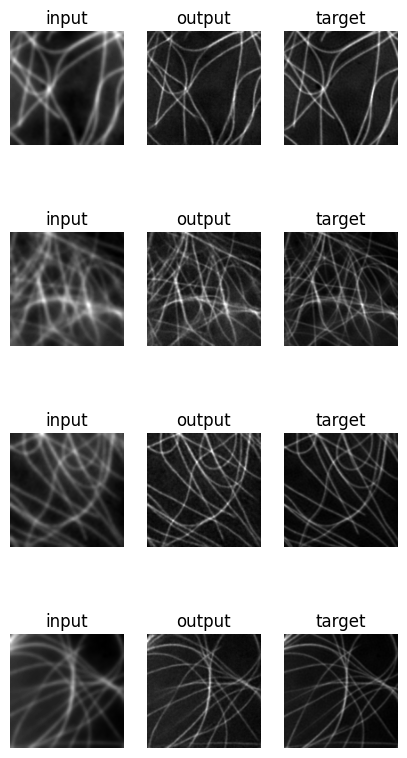



Epoch 30 / 30
__________
Batch 1 / 630: Train loss: 0.0426
Batch 201 / 630: Train loss: 0.0459
Batch 401 / 630: Train loss: 0.0387
Batch 601 / 630: Train loss: 0.0446
----------
Epoch 30/30 : Train loss: 0.0411
Time elapsed: 0:12:18.419170 



UNet inference: 100%|█████████████████████████████████████████████████████████████████████████▉| 1999/2000 [01:01<00:00, 32.28it/s]


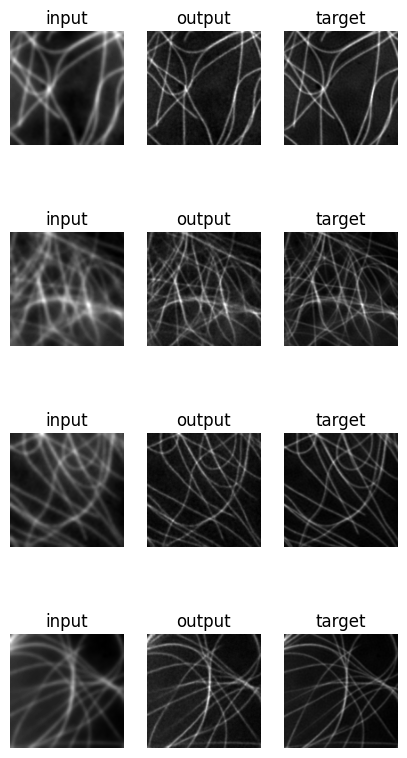

In [14]:
EPOCHS = 30

# Import the packages required for checking the time taken for each epoch
import time
from datetime import timedelta

# Create lists to store the training and validation loss
train_loss = []
val_loss = []

for epoch in range(EPOCHS):

    # Record the start time of the epoch
    start_time = time.time()

    num_batches = len(train_loader)

    print("\n")
    print(f"Epoch {epoch+1} / {EPOCHS}")
    print("_" * 10)

    model.train(True)

    running_loss = 0.0
    for batch_idx, (image, target) in enumerate(train_loader, start=0):
        
        # Prepare data
        x_t, t, noise = prepare_data(image, target)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(x_t, t)

        loss = criterion(outputs, noise)
        loss.backward()
        optimizer.step()

        # Print loss after certian number of batches
        if batch_idx % 200 == 0:
            print(f"Batch {batch_idx+1} / {num_batches}: Train loss: {loss.item():.4f}")

        # Update the running loss
        running_loss += loss.item()

    # Save the loss
    train_loss.append(running_loss / len(train_loader))

    # Validation loss
    # Set the model to evaluation mode at the end of each epoch
    model.eval()

    # Comment this part if you don't want to run the validation loss (memory intensive)
    with torch.no_grad():
        running_loss = 0.0
        for batch_idx, (image, target) in enumerate(val_loader):
            # Prepare data
            x_t, t, noise = prepare_data(image, target)

            # Forward pass
            outputs = model(x_t, t)
            loss = criterion(outputs, noise)

            # Update the running loss
            running_loss += loss.item()

        # Save the loss
        val_loss.append(running_loss / len(val_loader))

    # Print the loss for this epoch (Make sure to comment the validation loss part if you don't want to run it)
    end_time = time.time()
    print("-" * 10)
    print(
        f"Epoch {epoch+1}/{EPOCHS} : Train loss: {train_loss[-1]:.4f}, Val loss: {val_loss[-1]:.4f}"
    )
    # print(
    #     f"Epoch {epoch+1}/{EPOCHS} : Train loss: {train_loss[-1]:.4f}"
    # )
    print(f"Time elapsed: {timedelta(seconds=end_time-start_time)}", "\n")


    # Save predictions once in a while
    num_images = 4

    # Sample some images for the val loader
    for batch_idx, (image, target) in enumerate(val_loader):
        image = image[:num_images]

        generated_images = diffusion.sample_test_images(
            model,
            n=num_images,
            n_channels=1,  # Channels in the image
            position_encoding_dim=EMBEDDING_DIM,  # Positional encoding dimension
            position_encoding_function=positional_encoding,  # Positional encoding function
            input_image=image,
            save_every=200,
        )

        break

    # SR figure

    fig = plt.figure(figsize=(5, 10))
    n_images = image.shape[0]
    for i in range(n_images):
        image_diff_traj = generated_images[i]
        low_res_image = image[i]
        high_res_image = image_diff_traj[-1]
        target_image = target[i]

        # plot low res, high res and target image as (n_images, 3) subplot
        plt.subplot(n_images, 3, i * 3 + 1)
        plt.title("input")
        plt.imshow(denormalize(low_res_image), cmap="gray")
        plt.axis("off")
        plt.subplot(n_images, 3, i * 3 + 2)
        plt.title("output")
        plt.imshow(denormalize(high_res_image), cmap="gray")
        plt.axis("off")
        plt.subplot(n_images, 3, i * 3 + 3)
        plt.title("target")
        plt.imshow(denormalize(target_image), cmap="gray")
        plt.axis("off")

    plt.show()

### Sample images

Using the trained model, we will now generate some high-resolution images from the low-resolution images in the validation dataset.

In [ ]:
# Set the model to evaluation mode
model.eval()


num_images = 4

# Sample some images for the val loader
for batch_idx, (image, target) in enumerate(val_loader):
    image = image[:num_images]

    generated_images = diffusion.sample_test_images(
        model,
        n=num_images,
        n_channels=1,  # Channels in the image
        position_encoding_dim=EMBEDDING_DIM,  # Positional encoding dimension
        position_encoding_function=positional_encoding,  # Positional encoding function
        input_image=image,
        save_every=200,
    )

    break

# SR figure

fig = plt.figure(figsize=(5, 10))
n_images = image.shape[0]
for i in range(n_images):
    image_diff_traj = generated_images[i]
    low_res_image = image[i]
    high_res_image = image_diff_traj[-1]
    target_image = target[i]

    # plot low res, high res and target image as (n_images, 3) subplot
    plt.subplot(n_images, 3, i * 3 + 1)
    plt.title("input")
    plt.imshow(denormalize(low_res_image), cmap="gray")
    plt.axis("off")
    plt.subplot(n_images, 3, i * 3 + 2)
    plt.title("output")
    plt.imshow(denormalize(high_res_image), cmap="gray")
    plt.axis("off")
    plt.subplot(n_images, 3, i * 3 + 3)
    plt.title("target")
    plt.imshow(denormalize(target_image), cmap="gray")
    plt.axis("off")

plt.show()

### Plot losses

We now plot the losses for the training and validation datasets.

In [ ]:
plt.plot(train_loss, label="Train loss")
plt.plot(val_loss, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()